# RATIONAL MATRIX MACHINES

## Vector Fitting algorithm with expanded polynomial basis

## + Proximal Forward Backward Splitting algorithm for Pole-filtering regularization 

### a generalized L1-L2 group regularization for complex pole-residues feature space

>> ######    Homoscedastic & Heteroscedastic cases without polynomial background

##### a Python implementation by P. DUCRU


This program implements in Python 3 :
      - the simplest Vector Fitting algorithm (no complex conjugation for real case, no QR, no Relaxation, no othrogonal basis, etc.)
      - adds a polynomial entire part to the rational fit, of arbitrary order poly_order
      - Codes a PFBS algorithm for pole filtering

NOTE : author is Pablo DUCRU, for any inquires please e-mail at  *** p_ducru@mit.edu ***

In [1]:
## Import Python package for linear algebra
import numpy as np

In [2]:
## Import Python package for data management
#import pandas as pd

In [3]:
## Importing Python packages for plotting
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


The space of functions we are learning in is that of proper rational fraction of degree zero (poles + offset)

In [4]:
## Generic rational fractions with an offset and an entire part.
# > The entire part is specified by the set of coefficients.
# > If no coefficients are provided (the empty set), the rational function is build with a simple offset, the default value of which is zero.
def rational_function(z, poles, residues, offset=0, poly_coeff=()):
    if poly_coeff == ():
        poly_order = 0
        ## print("The rational_function function was not given an entire polynomial part to build.")
    else:
        poly_order = poly_coeff.shape[0]
    return  np.sum(residues[n]/(z-poles[n]) for n in range(poles.size)) + offset + np.sum(poly_coeff[n]*z**(n+1) for n in range(poly_order))

## Training data 

#### Import real learning and validation data

Read in cross sections 

## retrieve labers strings data
!wget https://www.dropbox.com/s/kfu0pjvrw2zky3h/temperature_cross_sections_Ce_140.csv?dl=0

## read in the cvs cross section data
cross_section_data = pd.read_csv('temperature_cross_sections_Ce_140.csv?dl=0') ## This dl=0 may change to dl=0.1,2,3.etc. if reading the Dropbox from another computer/during another session 
cross_section_data.shape

z_train = np.array(cross_section_data.Energy_eV, dtype=complex)
z_train = np.sqrt(z_train[180:490]) ## in sqrt of energy space making smaller for testing
z_train.shape

Y_train = np.array(cross_section_data.iloc[:,1:9].copy(), dtype=complex)
Y_train = Y_train[180:490,[0,4,7]] ## Y_train[200:475,[0,7]] 
Y_train = np.array([Y_train[n,:] for n in range(z_train.size)]) ##[z_train[n]*
Y_train.shape

## Ploting training data
fig_training_points = plt.figure()
plt.plot(z_train, Y_train)
plt.show()

fig_training_points_log = plt.figure()
plt.semilogy(z_train, Y_train)
plt.show()

#### Generate toy-problem training data

Generate labeled data:

We here only look at the case of vector residues, the matrix case with nuclear norm regularization will only necesitate an additional function to convert matrix to vector and back.

In [5]:
number_true_poles = 10
U = np.zeros([number_true_poles+2,number_true_poles+2])
for i in range(number_true_poles+2):
    for j in range(i,number_true_poles+2):
        U[i,j] = np.random.rand()/2
#print(U)
U = U + np.transpose(U)
#print(U)

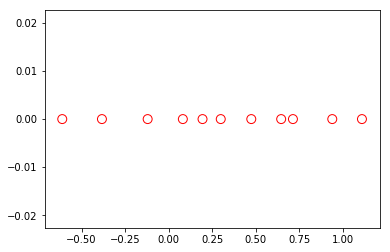

In [6]:
vp= np.sort(np.linalg.eig(U)[0][1:number_true_poles+2])
plt.scatter(np.real(vp), np.imag(vp), s=80, facecolors='none', edgecolors='r')
#plt.show()

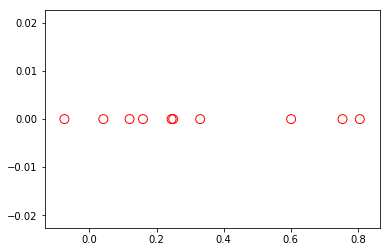

In [7]:
distances_vp = np.zeros([vp.size-1]) 
for k in range(vp.size-1):
    distances_vp[k] = vp[k+1] - vp[k]*np.random.rand()
plt.scatter(np.real(distances_vp), np.imag(distances_vp), s=80, facecolors='none', edgecolors='r')
#plt.show()

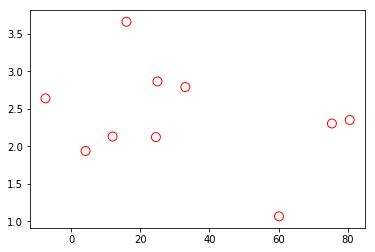

In [8]:
true_poles = 100*distances_vp + 0.2*1j*(np.random.chisquare(1,number_true_poles)+np.random.chisquare(2,number_true_poles)+np.random.chisquare(10,number_true_poles))
plt.scatter(np.real(true_poles), np.imag(true_poles), s=80, facecolors='none', edgecolors='r')
#plt.show()

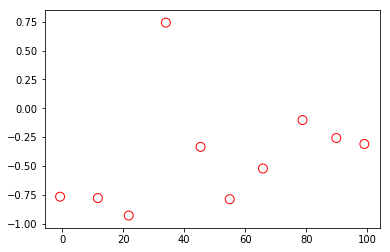

In [9]:
## True poles, generated at random
number_true_poles = 10  ## >Physics: number of resonances of the scattering matrix



true_poles = np.linspace(0, 100, number_true_poles) + np.array([ np.exp(1j*2*np.pi*np.random.rand()) for n in range(number_true_poles)])

plt.scatter(np.real(true_poles), np.imag(true_poles), s=80, facecolors='none', edgecolors='r')
plt.show()

In [10]:
## True residues, generated at random
dim_residues = 1 ## >Physics: size of the vectors being fitted, say your number of reaction channels (fission, scattering, γ-capture)
true_residues = 3*np.array([ np.exp(1j*2*np.pi*np.random.rand(dim_residues)) for n in range(number_true_poles)])
#Physical residues of different magnitude: 
#true_residues = 4*np.array([ ((true_poles[n]/number_true_poles)**0.5)*np.exp(1j*2*np.pi*np.random.rand(dim_residues)) for n in range(number_true_poles)])
#true_residues = 6*np.array([ ((np.random.rand()))*np.exp(1j*2*np.pi*np.random.rand(dim_residues)) for n in range(number_true_poles)])

In [11]:
## True offset
true_offset = np.array(np.random.rand(dim_residues))-np.array(np.random.rand(dim_residues))

In [12]:
## True polynomial coefficients
true_poly_order = 0
true_poly_coeff = 0.0*np.array([ (1/(n+1))*np.exp(1j*2*np.pi*np.random.rand(dim_residues)) for n in range(true_poly_order)])
#true_poly_coeff = 0.001*np.array([ (1/(n+1))*np.exp(1j*2*np.pi*np.random.rand(dim_residues)) for n in range(true_poly_order)])

Plot the true function

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  """
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  # Remove the CWD from sys.path while we load stuff.


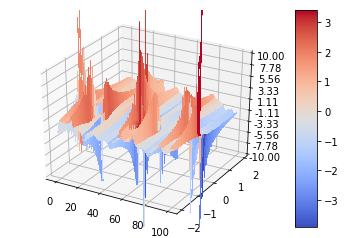

In [13]:
## Creating the figure
fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(-2, 101, 0.5)
Y = np.arange(-2, 2, 0.1)
Z = np.zeros([X.size, Y.size] , dtype=complex)
for i in range(X.size):
  for j in range(Y.size):
    Z[i,j] = rational_function(X[i]+1j*Y[j], true_poles, true_residues, true_offset, true_poly_coeff)[0]
Zr = np.real(Z)
Zi = np.imag(Z)
X, Y = np.meshgrid(X, Y)

# Plot the surface.
surf = ax.plot_surface(X, Y, Zr.T, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-10, 10)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=1, aspect=10)

plt.show()

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  """
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  # Remove the CWD from sys.path while we load stuff.


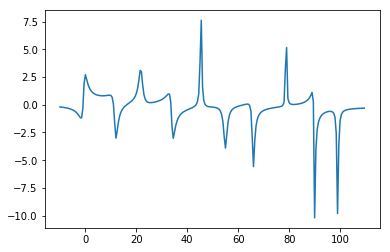

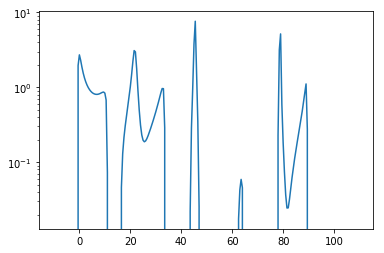

In [14]:
## Ploting along the real axis

x_grid = np.arange(-10, 110, 0.5)
Z_x = np.zeros([x_grid.size, dim_residues] , dtype=complex)
for i in range(x_grid.size):
   Z_x[i] = rational_function( x_grid[i], true_poles, true_residues, true_offset, true_poly_coeff)
Y_x = np.real(Z_x)
plt.plot(x_grid , Y_x)
plt.show()

plt.semilogy(x_grid , Y_x)
plt.show()

In [15]:
## Generating the training data (add statistical noise to test noisy data)
number_train_points = 180
## training mesh
z_train = np.linspace(-20, 120, number_train_points)  ## + np.exp(1j*2*np.pi*np.random.rand(number_train_points)) for complex 
## corresponding training points
Y_true = np.zeros([z_train.size, dim_residues] , dtype=complex)
Y_train = np.zeros([z_train.size, dim_residues] , dtype=complex)
μ =  0.0 ## mean deviation 
σ =  2.00 ## homeosckedastic case (full covariance for heterosckedastic case)
for k in range(z_train.size):
    Y_true[k] = rational_function(z_train[k], true_poles, true_residues, true_offset, true_poly_coeff) 
    ## Homoscedastic Normal: 
    Y_train[k] = rational_function(z_train[k], true_poles, true_residues, true_offset, true_poly_coeff)+ np.random.normal(μ, σ, dim_residues) ## Homoscedastic case
    ## Homoscedastic Cauchy: 
    #Y_train[k] = rational_function(z_train[k], true_poles, true_residues, true_offset, true_poly_coeff)+ 1.5*np.ones(dim_residues)*np.random.standard_cauchy()
    ## Linear heteroscedastic: Y_train[k] = rational_function(z_train[k], true_poles, true_residues, true_offset, true_poly_coeff)*( 1 + np.random.normal(μ, σ, dim_residues)) ## Linear Heteroscedastic case: 
    ## sqrt Homoscedastic: Y_train[k] = rational_function(z_train[k], true_poles, true_residues, true_offset, true_poly_coeff) + np.sqrt(np.linalg.norm(rational_function(z_train[k], true_poles, true_residues, true_offset, true_poly_coeff)))*np.random.normal(μ, σ, dim_residues) ## sqrt Heteroscedastic case: 
    
    
    ## Heteroscedastic case: y(k) + np.random.normal(0,sqrt(y(k)), dim_residues)
noise_relative_error = np.linalg.norm(Y_true - Y_train)/(np.linalg.norm(Y_true))
noise_relative_error

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  """
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  # Remove the CWD from sys.path while we load stuff.


0.9198260692811175

/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


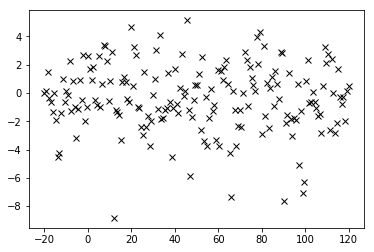

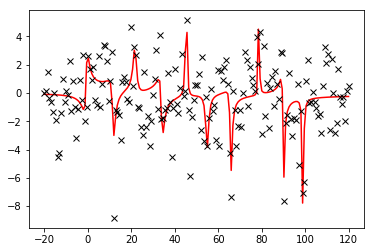

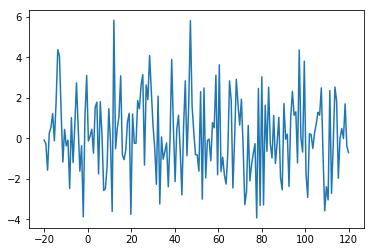

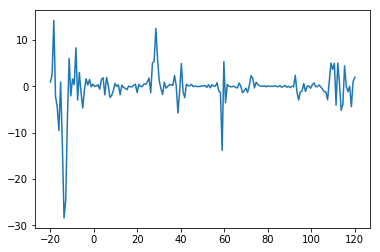

In [16]:
## Ploting the noisy training points upon the real data
fig_training_points = plt.figure()
#plt.plot(z_train, Y_true, 'r', label='Y_true')
plt.plot(z_train, Y_train, 'x k', label = 'Y_train')
plt.show()

fig_training_points = plt.figure()
plt.plot(z_train, Y_true, 'r', label='Y_true')
plt.plot(z_train, Y_train, 'x k', label = 'Y_train')
plt.show()

fig_training_points_diff = plt.figure()
plt.plot(z_train, Y_true - Y_train)
plt.show()


fig_training_points_rel_diff = plt.figure()
plt.plot(z_train, (Y_true - Y_train)/Y_true)
plt.show()

## Vector Fitting Algorithm



##### The simplest barycentric SK iterations: no relaxation, no QR, no orthogonal basis, no real numbers

#### VF algorithm

: Building functions that make up the building blocks of the algorithm

In [17]:
## build the square root of the rho_k weights for the LS system :: linear heteroscedastic case
def build_square_weights_rho_k(z_train, Y_train):
    number_train_points = z_train.size
    sqrt_weights_rho = np.zeros([number_train_points], dtype=np.complex)
    for k in range(number_train_points):
        sqrt_weights_rho[k] =  1.0/(np.sqrt(number_train_points)) # CHANGE HERE FOR HETEROSKEDASTIC *(np.sqrt(np.linalg.norm(Y_train[k])))))  ## * (np.linalg.norm(Y_train[k])) ))) ## for linear heteroscedastic case, add: *np.linalg.norm(Y_train[k]))
    return sqrt_weights_rho

In [18]:
## define the Cauchy matrix
def Cauchy_matrix(z,p):
    C = np.zeros([z.size , p.size],  dtype=np.complex)
    for k in range(z.size):
        for j in range(p.size):
            C[k,j] = 1/(z[k] - p[j])
    return C

In [19]:
## define the Vandermonde matrix without offset
def Vandermonde_matrix(z,poly_order):
    V = np.zeros([z.size , poly_order],  dtype=np.complex)
    for k in range(z.size):
        for n in range(poly_order):
            V[k,n] = z[k]**(n+1)
    return V

In [20]:
## Create the Y_vector for the LS problem :: Here, we weight it with the sqrt of the rho_k for the system
def vectorize_Y_for_LS(z_train, Y_train, dim_residues):
    number_train_points = Y_train.shape[0]
    sqrt_weights_rho = build_square_weights_rho_k(z_train, Y_train)
    Y_LS_vector = np.zeros([dim_residues*number_train_points],  dtype=np.complex)
    for d in range(dim_residues):
        for k in range(number_train_points):
            Y_LS_vector[d*number_train_points + k] =  sqrt_weights_rho[k]*Y_train[k,d]
    return Y_LS_vector

In [21]:
## build the matrix of the barycentric LS system:
def build_barycentric_LS_matrix(z_train, Y_train, learn_poles, poly_order=0):
  dim_residues = Y_train[0].size
  number_train_points = z_train.size
  number_poles_learn = learn_poles.size
  sqrt_weights_rho = build_square_weights_rho_k(z_train, Y_train) 
  C = Cauchy_matrix(z_train, learn_poles)
  V = Vandermonde_matrix(z_train,poly_order)
  LS_matrix = np.zeros([dim_residues*number_train_points, dim_residues*(number_poles_learn+1+poly_order) + number_poles_learn],  dtype=np.complex)
  for d in range(dim_residues):
      for k in range(number_train_points):
          for p in range(number_poles_learn):
              LS_matrix[d*number_train_points + k, d*number_poles_learn + p] = sqrt_weights_rho[k]*C[k,p]
              for n in range(poly_order):
                  LS_matrix[d*number_train_points + k, dim_residues*number_poles_learn + d*poly_order + n] = sqrt_weights_rho[k]*V[k,n] 
              LS_matrix[d*number_train_points + k, dim_residues*(number_poles_learn+poly_order) + d] = sqrt_weights_rho[k]*1 
              LS_matrix[d*number_train_points + k, dim_residues*(number_poles_learn+poly_order+1) + p] = -sqrt_weights_rho[k]*Y_train[k,d]*C[k,p]
  return LS_matrix

In [22]:
## build the matrix of the simple LS system:
def build_LS_matrix(z_train, Y_train, learn_poles, poly_order=0):
  dim_residues = Y_train[0].size
  number_train_points = z_train.size
  number_poles_learn = learn_poles.size
  sqrt_weights_rho = build_square_weights_rho_k(z_train, Y_train) 
  C = Cauchy_matrix(z_train, learn_poles)
  V = Vandermonde_matrix(z_train,poly_order)
  LS_matrix = np.zeros([dim_residues*number_train_points, dim_residues*(number_poles_learn+1+poly_order) ],  dtype=np.complex)
  for d in range(dim_residues):
      for k in range(number_train_points):
          for p in range(number_poles_learn):
              LS_matrix[d*number_train_points + k, d*number_poles_learn + p] = sqrt_weights_rho[k]*C[k,p]  
              for n in range(poly_order):
                  LS_matrix[d*number_train_points + k, dim_residues*number_poles_learn + d*poly_order + n] = sqrt_weights_rho[k]*V[k,n] 
              LS_matrix[d*number_train_points + k, dim_residues*(number_poles_learn+poly_order) + d] = sqrt_weights_rho[k]*1 
  return LS_matrix

In [23]:
## Function that vectorizes the residues and offset for the problem
def build_LS_vector(residues, offset, poly_coeff=()):
    if type(poly_coeff) == tuple:
        poly_order = 0
        #print("The build_LS_vector function was not given an entire polynomial part to build.") 
    else:
        poly_order = poly_coeff.shape[0]
    number_poles = residues.shape[0]
    dim_residues = residues.shape[1]
    LS_vector    = np.zeros([dim_residues*(number_poles+poly_order+1)], dtype=np.complex)
    for d in range(dim_residues):
        for p in range(number_poles):
            LS_vector[d*number_poles + p] = residues[p][d]
        for n in range(poly_order):
            LS_vector[dim_residues*number_poles + d*poly_order + n] = poly_coeff[n][d]
    LS_vector[dim_residues*(number_poles+poly_order):LS_vector.size] = offset
    return LS_vector

In [24]:
## Function that takes the vectorized solution and spits out the different elements
def extract_from_LS_vector(LS_vector, number_poles, dim_residues , poly_order=0):
    residues = np.zeros([number_poles, dim_residues], dtype=np.complex)
    poly_coeff = np.zeros([poly_order, dim_residues], dtype=np.complex)
    offset   = np.zeros([dim_residues], dtype = np.complex)
    for d in range(dim_residues): 
        for p in range(number_poles):
            residues[p][d] = LS_vector[d*number_poles + p]
        for n in range(poly_order):
            poly_coeff[n][d] = LS_vector[dim_residues*number_poles + d*poly_order + n]
    offset = LS_vector[dim_residues*(number_poles+poly_order) : LS_vector.size]
    if poly_order == 0:
        return residues, offset
    else:
        return residues, poly_coeff, offset

**The Vector Fitting algorithm: **

The algorithm takes as input a training set {z_k, Y_k}, composed of training vectors {Y_k}, matched on a grid {z_k}.

A standard number of VF iterations is 10, which usually suffices to converge the poles. 

Our implementation does not require the input of an initial guess. If you do not give one, the program will come up with a linearly spaced complex diagonal along the rectangle of the mesh of training points on the complex plane. 

In [25]:
def VF_algorithm(z_train, Y_train, number_VF_iteration, poly_order = 0 , *arguments ):
    ## build the Y vector to solve for:
    dim_residues = Y_train[0].size
    number_train_points = z_train.size
    Y_LS_vector = vectorize_Y_for_LS(z_train, Y_train, dim_residues)
    ## Initialize the poles
    if arguments == ():
        raise AssertionError("The VF_algorithm function must be given either a number of poles, or an array of initial poles guess") 
    for arg in arguments:
        if type(arg) == np.ndarray: ## was given an initial guess as argument
            print(" The VF_algorithm was provided an initial guess for the poles")
            learn_poles = arg
            number_poles = learn_poles.size
        elif type(arg) == int: ## was given a number of poles without any initial guess
            print("The VF_algorithm was provided a number of poles to learn and is generating an initial guess")
            number_poles = arg
            if (np.amax(np.imag(z_train)) - np.amin(np.imag(z_train))) == 0: ## only real training data
                print("The training points are only along the real axis, and the initial guesses are generated accordingly with a shift")
                learn_poles = np.linspace(np.amin(np.real(z_train))+1/(10*(np.amax(np.real(z_train)) - np.amin(np.real(z_train)))),np.amax(np.real(z_train)) + 1/(10*(np.amin(np.real(z_train))-np.amax(np.real(z_train)))) , number_poles) + 1j*np.linspace(np.amin(np.imag(z_train)),np.amax(np.imag(z_train)), number_poles)
            elif (np.amax(np.real(z_train)) - np.amin(np.real(z_train)) ) == 0:
                print("The training points are exactly along the imaginary axis, and the initial guesses are generated accordingly with a shift")
                learn_poles = np.linspace(np.amin(np.real(z_train)),np.amax(np.real(z_train)) , number_poles) + 1j*np.linspace(np.amin(np.imag(z_train)) + 1/(10*(np.amax(np.imag(z_train)) - np.amin(np.imag(z_train)))) ,np.amax(np.imag(z_train)) - 1/(10*(np.amax(np.imag(z_train)) - np.amin(np.imag(z_train)))), number_poles)
            else:
                learn_poles = np.linspace(np.amin(np.real(z_train))+1/(10*(np.amax(np.real(z_train))-np.amin(np.real(z_train)))),np.amax(np.real(z_train)) - 1/(10*(np.amax(np.real(z_train)) - np.amin(np.real(z_train)))) , number_poles) + 1j*np.linspace(np.amin(np.imag(z_train)) + 1/(10*(np.amax(np.imag(z_train)) - np.amin(np.imag(z_train)))), np.amax(np.imag(z_train)) -  1/(10*(np.amax(np.imag(z_train)) - np.amin(np.imag(z_train)))) , number_poles)
    ## POLE CONVERGENCE: Run the VF iterations 
    for i in range(number_VF_iteration):
        ## build the barycentric L2 system
        barycentric_LS_matrix = build_barycentric_LS_matrix(z_train, Y_train, learn_poles, poly_order)
        ## solve the barycentric L2 system
        barycentric_LS_vector , barycentric_LS_residual , barycentric_LS_rank , barycentric_LS_singular_values = np.linalg.lstsq(barycentric_LS_matrix, Y_LS_vector, poly_order)
        ## extract the barycentric residues
        barycentric_residues = barycentric_LS_vector[dim_residues*(learn_poles.size + poly_order +1):barycentric_LS_vector.size]
        ## Build the matrix the spectrum of which will be the recolated poles
        P = np.diag(learn_poles) - np.tensordot(barycentric_residues,np.ones([barycentric_residues.size], dtype=np.complex),0)
        ## Solve the spectral problem & relocate poles
        learn_poles , eigenvectors = np.linalg.eig(P)
        ## convergence criteria
    ## RESIDUES EXTRACTION: Solve the LS system
    ## build the quadratic system
    LS_matrix = build_LS_matrix(z_train, Y_train, learn_poles, poly_order)
    ## solve the quadratic L2 system
    LS_vector, LS_residual, LS_rank , LS_singular_values = np.linalg.lstsq(LS_matrix, Y_LS_vector) ## np.linalg.solve(A.T.dot(A) + lamb * np.identity(n_col), A.T.dot(y)) For Tichonov
    ## extract the residues, polynomial coefficients and offset
    if poly_order == 0:
        VF_poly_coeff= np.array([ 0.0 for n in range(poly_order)])
        VF_residues , VF_offset = extract_from_LS_vector(LS_vector, learn_poles.size, dim_residues)
        return learn_poles, VF_residues, VF_poly_coeff, VF_offset, LS_residual, barycentric_residues ## Artificially added an emplty set of VF_poly_coeff for homogeneity
    else:
        VF_residues , VF_poly_coeff, VF_offset = extract_from_LS_vector(LS_vector, learn_poles.size, dim_residues, poly_order)
        return learn_poles, VF_residues, VF_poly_coeff, VF_offset, LS_residual, barycentric_residues

#### Results benchmarking and analysis


VF algorithm results

In [26]:
VF_poles, VF_residues, VF_poly_coeff, VF_offset, VF_residual, barycentric_residues = VF_algorithm(z_train, Y_train, 30, 0, 20) ## add VF_poly_coeff when poly_order not zero 

The VF_algorithm was provided a number of poles to learn and is generating an initial guess
The training points are only along the real axis, and the initial guesses are generated accordingly with a shift


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [27]:
## VF results
z_train  ## for complex values : 2*np.random.rand(number_CV_points)*np.exp(1j*2*np.pi*np.random.rand(number_CV_points))
dim_residues = Y_train[0].size
Y_VF = np.zeros([z_train.size, dim_residues] , dtype=complex) ## VF solution
for k in range(z_train.size):
    Y_VF[k] = rational_function(z_train[k], VF_poles, VF_residues, VF_offset) # add when poly_order not zero : VF_poly_coeff)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  # Remove the CWD from sys.path while we load stuff.


Plotting Vector Fitting results

/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


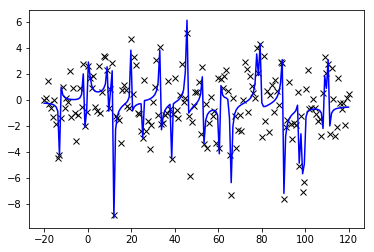

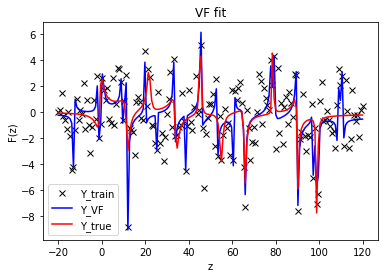

In [28]:
fig_train_vs_VF = plt.figure()
plt.plot(z_train, Y_train, 'x k', label='Y_train' )
plt.plot(z_train, Y_VF, 'b', label='Y_VF')
#plt.plot(z_train, Y_true, 'r', label='Y_true')

fig_train_vs_VF = plt.figure()
plt.plot(z_train, Y_train, 'x k', label='Y_train' )
plt.plot(z_train, Y_VF, 'b', label='Y_VF')
plt.plot(z_train, Y_true, 'r', label='Y_true')

#plt.ylim(-20,20)
plt.xlabel('z')
plt.ylabel('F(z)')
plot_title = 'VF fit'
plt.title(plot_title)
plt.legend()
#plt.show()
plt.rcParams['axes.facecolor'] = '0.98'


## PFBS algorithm for Elastic Net group regularization

We here implement a Proximal Forward-Backward Splitting (PFBS) algorithm for complex Frobenius group-LASSO regularization, with a Tichonov L2 regularization, solving the Elastic Net problem.

Of critical importance is the fact that the Frobenius norm of a Matrix and its assciated vector are the same. This will not be true of the nuclear norm, where the vectors will have to be compacted back as matrices.


##### Purpose
The Goal of this standard approach is to show that it DOES NOT perform well on our problem (even though many people would think it does), whereas our Pole Filtering regularization DOES work very well (because we though about the nature of the feature space). 

#### PFBS algorithm 

Proximal operator for the Frobenius norm under cartesian differentiation 

In [29]:
## Proximal operator for L1-L2 group regularization
def prox_λ(A,λ):
    return A*max(0,1-λ/np.linalg.norm(A))

Our PFBS iterations solve the Elastic net Regularization problem (default LASSO and Tichonov Regularizations are zero, yielding the LS problem).

The convergence criteria are given by a relative change threshold, as well as a total amount of iterations. The default values are 2000 iterations, and 10e-8 relative step sizes stop iteration convergence. 

In [30]:
def PFBS_Elastic_Net_algorithm(z_train, Y_train, poles , λ=0 , μ=0, num_PFBS_iter = 2000 , ε = 1.0e-8 ):
    ## build the LS vectors and matrix
    number_poles = poles.size
    dim_residues = Y_train[0].size
    Y_LS_vector = vectorize_Y_for_LS(z_train, Y_train, dim_residues)
    Z = build_LS_matrix(z_train, Y_train, poles)
    ## calculate the γ step size
    ZZ = np.tensordot(Z.conj().T,Z,1)
    eigenvals , eigenvects = np.linalg.eig(ZZ)
    γ = 1/(2*np.amax(eigenvals))
    ## condition number of this system
    Condition_number = np.amax(eigenvals)/np.amin(eigenvals)
    ## initiatilze the PFBS descent with the LS residues
    LS_vector, LS_residual, LS_rank , LS_singular_values = np.linalg.lstsq(Z, Y_LS_vector)
    PFBS_vector = LS_vector
    ## start PFBS iterations
    PFBS_iter_num = 0
    for i in range(num_PFBS_iter):
        ## report the old vector
        PFBS_old_residues, PFBS_old_offset = extract_from_LS_vector(PFBS_vector,number_poles, dim_residues)
        ## iteration count
        PFBS_iter_num += 1 
        ## compute the Gradient
        ΔE = 2*np.tensordot(Z.conj().T, (np.tensordot(Z,PFBS_vector, 1) - Y_LS_vector), 1)
        ## Add the Tichonov regularization on the residues
        ΔEμ = ΔE 
        ΔEμ[:dim_residues*number_poles] = ΔE[:dim_residues*number_poles] + 2*μ*PFBS_vector[:dim_residues*number_poles]
        ## take the Gradient descent step
        GD_new_PFBS_vector = PFBS_vector - γ*ΔEμ
        GD_new_residues, GD_new_offset = extract_from_LS_vector(GD_new_PFBS_vector, number_poles, dim_residues)
        ## take the PFBS step for group LASSO regularization
        PFBS_new_residues = GD_new_residues
        ΔL2_relative_step_size = np.zeros([number_poles])
        for p in range(number_poles):
            PFBS_new_residues[p] = prox_λ(GD_new_residues[p],λ)
            ## calculate the PFBS step size for convergence criteria
            if np.linalg.norm(PFBS_new_residues[p]) == 0:
                ΔL2_relative_step_size[p] = 0
            else: 
                ΔL2_relative_step_size[p] = np.linalg.norm(PFBS_new_residues[p] - PFBS_old_residues[p])/(np.linalg.norm(PFBS_new_residues[p]))
        ## update PFBS_vector
        PFBS_vector = build_LS_vector(PFBS_new_residues, GD_new_offset)
        ## convergence criteria on the relative step size 
        if np.amax(ΔL2_relative_step_size) < ε:
            print("The λ regularization parameter is λ =", λ, "the maximum relative step sizes in norm is max(ΔL2_relative_step_size) =" , np.amax(ΔL2_relative_step_size), "for threshold ε =", ε, "and the PFBS iterations are breaking after PFBS_iter_num =", PFBS_iter_num, "iterations")
            break
    PFBS_residues, PFBS_offset = extract_from_LS_vector(PFBS_vector, number_poles, dim_residues)
    return PFBS_residues, PFBS_offset , γ , Condition_number, PFBS_iter_num

#### Results of the PFBS algorithm

The PFBS algorithm results

In [31]:
PFBS_Elastic_Net_residues, PFBS_Elastic_Net_offset , γ , Elastic_Net_Condition_number, PFBS_Elastic_Net_iter_num = PFBS_Elastic_Net_algorithm(z_train, Y_train, VF_poles , 0.02, 0.0)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


The λ regularization parameter is λ = 0.02 the maximum relative step sizes in norm is max(ΔL2_relative_step_size) = 9.83698279829881e-09 for threshold ε = 1e-08 and the PFBS iterations are breaking after PFBS_iter_num = 479 iterations


In [32]:
## PFBS results
z_train  ## for complex values : 2*np.random.rand(number_CV_points)*np.exp(1j*2*np.pi*np.random.rand(number_CV_points))
dim_residues = Y_train[0].size
Y_PFBS = np.zeros([z_train.size, dim_residues] , dtype=complex) ## VF solution
for k in range(z_train.size):
    Y_PFBS[k] = rational_function(z_train[k], VF_poles, PFBS_Elastic_Net_residues, PFBS_Elastic_Net_offset )

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  # Remove the CWD from sys.path while we load stuff.


/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


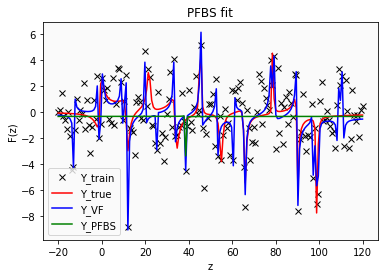

In [33]:
fig_train_vs_VF = plt.figure()
plt.plot(z_train, Y_train, 'x k', label='Y_train' )
plt.plot(z_train, Y_true, 'r', label='Y_true')
plt.plot(z_train, Y_VF, 'b', label='Y_VF')
plt.plot(z_train, Y_PFBS, 'g', label='Y_PFBS')



#plt.ylim(-10, 20)
plt.xlabel('z')
plt.ylabel('F(z)')
plot_title = 'PFBS fit'
plt.title(plot_title)
plt.legend()
#plt.show()
plt.rcParams['axes.facecolor'] = '0.98'

## Pole Filtering Regularization

We here define a pole-filtering regularization, as explained in the equations of article here:
https://www.overleaf.com/read/vjrwkmvhdzdg

In [34]:
## Proximal operator for L1-L2 group regularization
def prox_λ(A,λ):
    return A*max(0,1-λ/np.linalg.norm(A))

In [35]:
def Pole_filtering_regularization(z_train, Y_train, poles , λ=0 , μ=0, num_PFBS_iter = 2000 , ε = 1.0e-8 ):
    ## build the LS vectors and matrix
    number_poles = poles.size
    dim_residues = Y_train[0].size
    Y_LS_vector = vectorize_Y_for_LS(z_train, Y_train, dim_residues)
    Z = build_LS_matrix(z_train, Y_train, poles)
    ## calculate the least distances from z_k to poles:
    min_distances_z_p = np.zeros( [number_poles] , dtype=complex )
    for p in range(poles.size):
        min_distances_z_p[p] = np.abs(poles[p] - z_train[0])
        for k in range(z_train.size):
            if np.abs(poles[p] - z_train[k]) < min_distances_z_p[p] :
                min_distances_z_p[p] = np.abs(poles[p] - z_train[k])
    ## calculate the γ step size
    ZZ = np.tensordot(Z.conj().T,Z,1)
    eigenvals , eigenvects = np.linalg.eig(ZZ)
    γ = 1/(2*np.amax(eigenvals))
    ## condition number of this system
    Condition_number = np.amax(eigenvals)/np.amin(eigenvals)
    ## initiatilze the PFBS descent with the LS residues
    LS_vector, LS_residual, LS_rank , LS_singular_values = np.linalg.lstsq(Z, Y_LS_vector)
    PFBS_vector = LS_vector
    ## start PFBS iterations
    PFBS_iter_num = 0
    for i in range(num_PFBS_iter):
        ## report the old vector
        PFBS_old_residues, PFBS_old_offset = extract_from_LS_vector(PFBS_vector,number_poles, dim_residues)
        ## iteration count
        PFBS_iter_num += 1 
        ## compute the Gradient
        ΔE = 2*np.tensordot(Z.conj().T, (np.tensordot(Z,PFBS_vector, 1) - Y_LS_vector), 1)
        ## Add the Tichonov regularization on the residues
        ΔEμ = ΔE 
        ΔEμ[:dim_residues*number_poles] = ΔE[:dim_residues*number_poles] + 2*μ*PFBS_vector[:dim_residues*number_poles]
        ## take the Gradient descent step
        GD_new_PFBS_vector = PFBS_vector - γ*ΔEμ
        GD_new_residues, GD_new_offset = extract_from_LS_vector(GD_new_PFBS_vector, number_poles, dim_residues)
        ## take the PFBS step for group LASSO regularization
        PFBS_new_residues = GD_new_residues
        ΔL2_relative_step_size = np.zeros([number_poles])
        for p in range(number_poles):
            PFBS_new_residues[p] = prox_λ(GD_new_residues[p],λ/min_distances_z_p[p])
            ## calculate the PFBS step size for convergence criteria
            if np.linalg.norm(PFBS_new_residues[p]) == 0:
                ΔL2_relative_step_size[p] = 0
            else: 
                ΔL2_relative_step_size[p] = np.linalg.norm(PFBS_new_residues[p] - PFBS_old_residues[p])/(np.linalg.norm(PFBS_new_residues[p]))
        ## update PFBS_vector
        PFBS_vector = build_LS_vector(PFBS_new_residues, GD_new_offset)
        ## convergence criteria on the relative step size 
        if np.amax(ΔL2_relative_step_size) < ε:
            print("The λ regularization parameter is λ =", λ, "the maximum relative step sizes in norm is max(ΔL2_relative_step_size) =" , np.amax(ΔL2_relative_step_size), "for threshold ε =", ε, "and the PFBS iterations are breaking after PFBS_iter_num =", PFBS_iter_num, "iterations")
            break
    PFBS_residues, PFBS_offset = extract_from_LS_vector(PFBS_vector, number_poles, dim_residues)
    return PFBS_residues, PFBS_offset , γ , Condition_number, PFBS_iter_num

In [36]:
def Pole_squared_filtering_regularization(z_train, Y_train, poles , λ=0 , μ=0, num_PFBS_iter = 2000 , ε = 1.0e-8 ):
    ## build the LS vectors and matrix
    number_poles = poles.size
    dim_residues = Y_train[0].size
    Y_LS_vector = vectorize_Y_for_LS(z_train, Y_train, dim_residues)
    Z = build_LS_matrix(z_train, Y_train, poles)
    ## calculate the least distances from z_k to poles:
    min_distances_z_p = np.zeros( [number_poles] , dtype=complex )
    for p in range(poles.size):
        min_distances_z_p[p] = np.abs(poles[p] - z_train[0])
        for k in range(z_train.size):
            if np.abs(poles[p] - z_train[k]) < min_distances_z_p[p] :
                min_distances_z_p[p] = np.abs(poles[p] - z_train[k])
    ## calculate the γ step size
    ZZ = np.tensordot(Z.conj().T,Z,1)
    eigenvals , eigenvects = np.linalg.eig(ZZ)
    γ = 1/(2*np.amax(eigenvals))
    ## condition number of this system
    Condition_number = np.amax(eigenvals)/np.amin(eigenvals)
    ## initiatilze the PFBS descent with the LS residues
    LS_vector, LS_residual, LS_rank , LS_singular_values = np.linalg.lstsq(Z, Y_LS_vector)
    PFBS_vector = LS_vector
    ## start PFBS iterations
    PFBS_iter_num = 0
    for i in range(num_PFBS_iter):
        ## report the old vector
        PFBS_old_residues, PFBS_old_offset = extract_from_LS_vector(PFBS_vector,number_poles, dim_residues)
        ## iteration count
        PFBS_iter_num += 1 
        ## compute the Gradient
        ΔE = 2*np.tensordot(Z.conj().T, (np.tensordot(Z,PFBS_vector, 1) - Y_LS_vector), 1)
        ## Add the Tichonov regularization on the residues
        ΔEμ = ΔE 
        ΔEμ[:dim_residues*number_poles] = ΔE[:dim_residues*number_poles] + 2*μ*PFBS_vector[:dim_residues*number_poles]
        ## take the Gradient descent step
        GD_new_PFBS_vector = PFBS_vector - γ*ΔEμ
        GD_new_residues, GD_new_offset = extract_from_LS_vector(GD_new_PFBS_vector, number_poles, dim_residues)
        ## take the PFBS step for group LASSO regularization
        PFBS_new_residues = GD_new_residues
        ΔL2_relative_step_size = np.zeros([number_poles])
        for p in range(number_poles):
            PFBS_new_residues[p] = prox_λ(GD_new_residues[p],λ/(min_distances_z_p[p]**2))
            ## calculate the PFBS step size for convergence criteria
            if np.linalg.norm(PFBS_new_residues[p]) == 0:
                ΔL2_relative_step_size[p] = 0
            else: 
                ΔL2_relative_step_size[p] = np.linalg.norm(PFBS_new_residues[p] - PFBS_old_residues[p])/(np.linalg.norm(PFBS_new_residues[p]))
        ## update PFBS_vector
        PFBS_vector = build_LS_vector(PFBS_new_residues, GD_new_offset)
        ## convergence criteria on the relative step size 
        if np.amax(ΔL2_relative_step_size) < ε:
            print("The λ regularization parameter is λ =", λ, "the maximum relative step sizes in norm is max(ΔL2_relative_step_size) =" , np.amax(ΔL2_relative_step_size), "for threshold ε =", ε, "and the PFBS iterations are breaking after PFBS_iter_num =", PFBS_iter_num, "iterations")
            break
    PFBS_residues, PFBS_offset = extract_from_LS_vector(PFBS_vector, number_poles, dim_residues)
    return PFBS_residues, PFBS_offset , γ , Condition_number, PFBS_iter_num

In [37]:
def RMM_regularization(z_train, Y_train, poles , λ=0 , μ=0, num_PFBS_iter = 2000 , ε = 1.0e-8 ):
    ## build the LS vectors and matrix
    number_poles = poles.size
    dim_residues = Y_train[0].size  
    Y_LS_vector = vectorize_Y_for_LS(z_train, Y_train, dim_residues)
    Z = build_LS_matrix(z_train, Y_train, poles)
    ## calculate the least distances from z_k to poles:
    γ_R_p = np.zeros( [number_poles] , dtype=complex )
    sqrt_weights_rho = build_square_weights_rho_k(z_train, Y_train) 
    for p in range(poles.size):
        γ_R_p_inv = 0
        for k in range(z_train.size):
            γ_R_p_inv += 2*(sqrt_weights_rho[k]/np.abs(z_train[k] - poles[p]) )**2
        γ_R_p[p] = (1/γ_R_p_inv)**0.5
    ## calculate the γ step size
    ZZ = np.tensordot(Z.conj().T,Z,1)
    eigenvals , eigenvects = np.linalg.eig(ZZ)
    γ = 1/(2*np.amax(eigenvals))
    ## condition number of this system
    Condition_number = np.amax(eigenvals)/np.amin(eigenvals)
    ## initiatilze the PFBS descent with the LS residues
    LS_vector, LS_residual, LS_rank , LS_singular_values = np.linalg.lstsq(Z, Y_LS_vector)
    PFBS_vector = LS_vector
    ## start PFBS iterations
    PFBS_iter_num = 0
    for i in range(num_PFBS_iter):
        ## report the old vector
        PFBS_old_residues, PFBS_old_offset = extract_from_LS_vector(PFBS_vector,number_poles, dim_residues)
        ## iteration count
        PFBS_iter_num += 1 
        ## compute the Gradient
        ΔE = 2*np.tensordot(Z.conj().T, (np.tensordot(Z,PFBS_vector, 1) - Y_LS_vector), 1)
        ## Add the Tichonov regularization on the residues
        ΔEμ = ΔE 
        ΔEμ[:dim_residues*number_poles] = ΔE[:dim_residues*number_poles] + 2*μ*PFBS_vector[:dim_residues*number_poles]
        ## take the Gradient descent step
        GD_new_PFBS_vector = PFBS_vector - γ*ΔEμ
        GD_new_residues, GD_new_offset = extract_from_LS_vector(GD_new_PFBS_vector, number_poles, dim_residues)
        ## take the PFBS step for group LASSO regularization
        PFBS_new_residues = GD_new_residues
        ΔL2_relative_step_size = np.zeros([number_poles])
        for p in range(number_poles):
            PFBS_new_residues[p] = prox_λ(GD_new_residues[p],λ/γ_R_p[p])
            ## calculate the PFBS step size for convergence criteria
            if np.linalg.norm(PFBS_new_residues[p]) == 0:
                ΔL2_relative_step_size[p] = 0
            else: 
                ΔL2_relative_step_size[p] = np.linalg.norm(PFBS_new_residues[p] - PFBS_old_residues[p])/(np.linalg.norm(PFBS_new_residues[p]))
        ## update PFBS_vector
        PFBS_vector = build_LS_vector(PFBS_new_residues, GD_new_offset)
        ## convergence criteria on the relative step size 
        if np.amax(ΔL2_relative_step_size) < ε:
            print("The λ regularization parameter is λ =", λ, "the maximum relative step sizes in norm is max(ΔL2_relative_step_size) =" , np.amax(ΔL2_relative_step_size), "for threshold ε =", ε, "and the PFBS iterations are breaking after PFBS_iter_num =", PFBS_iter_num, "iterations")
            break
    PFBS_residues, PFBS_offset = extract_from_LS_vector(PFBS_vector, number_poles, dim_residues)
    return PFBS_residues, PFBS_offset , γ , Condition_number, PFBS_iter_num

In [38]:
def RMM2_regularization(z_train, Y_train, poles , λ=0 , μ=0, num_PFBS_iter = 2000 , ε = 1.0e-8 ):
    ## build the LS vectors and matrix
    number_poles = poles.size
    dim_residues = Y_train[0].size  
    Y_LS_vector = vectorize_Y_for_LS(z_train, Y_train, dim_residues)
    Z = build_LS_matrix(z_train, Y_train, poles)
    ## calculate the least distances from z_k to poles:
    γ_R_p = np.zeros( [number_poles] , dtype=complex )
    sqrt_weights_rho = build_square_weights_rho_k(z_train, Y_train) 
    for p in range(poles.size):
        γ_R_p_inv = 0
        for k in range(z_train.size):
            γ_R_p_inv += 2*(sqrt_weights_rho[k]/np.abs(z_train[k] - poles[p]) )**2
        γ_R_p[p] = 1/γ_R_p_inv
    ## calculate the γ step size
    ZZ = np.tensordot(Z.conj().T,Z,1)
    eigenvals , eigenvects = np.linalg.eig(ZZ)
    γ = 1/(2*np.amax(eigenvals))
    ## condition number of this system
    Condition_number = np.amax(eigenvals)/np.amin(eigenvals)
    ## initiatilze the PFBS descent with the LS residues
    LS_vector, LS_residual, LS_rank , LS_singular_values = np.linalg.lstsq(Z, Y_LS_vector)
    PFBS_vector = LS_vector
    ## start PFBS iterations
    PFBS_iter_num = 0
    for i in range(num_PFBS_iter):
        ## report the old vector
        PFBS_old_residues, PFBS_old_offset = extract_from_LS_vector(PFBS_vector,number_poles, dim_residues)
        ## iteration count
        PFBS_iter_num += 1 
        ## compute the Gradient
        ΔE = 2*np.tensordot(Z.conj().T, (np.tensordot(Z,PFBS_vector, 1) - Y_LS_vector), 1)
        ## Add the Tichonov regularization on the residues
        ΔEμ = ΔE 
        ΔEμ[:dim_residues*number_poles] = ΔE[:dim_residues*number_poles] + 2*μ*PFBS_vector[:dim_residues*number_poles]
        ## take the Gradient descent step
        GD_new_PFBS_vector = PFBS_vector - γ*ΔEμ
        GD_new_residues, GD_new_offset = extract_from_LS_vector(GD_new_PFBS_vector, number_poles, dim_residues)
        ## take the PFBS step for group LASSO regularization
        PFBS_new_residues = GD_new_residues
        ΔL2_relative_step_size = np.zeros([number_poles])
        for p in range(number_poles):
            PFBS_new_residues[p] = prox_λ(GD_new_residues[p],λ/γ_R_p[p])
            ## calculate the PFBS step size for convergence criteria
            if np.linalg.norm(PFBS_new_residues[p]) == 0:
                ΔL2_relative_step_size[p] = 0
            else: 
                ΔL2_relative_step_size[p] = np.linalg.norm(PFBS_new_residues[p] - PFBS_old_residues[p])/(np.linalg.norm(PFBS_new_residues[p]))
        ## update PFBS_vector
        PFBS_vector = build_LS_vector(PFBS_new_residues, GD_new_offset)
        ## convergence criteria on the relative step size 
        if np.amax(ΔL2_relative_step_size) < ε:
            print("The λ regularization parameter is λ =", λ, "the maximum relative step sizes in norm is max(ΔL2_relative_step_size) =" , np.amax(ΔL2_relative_step_size), "for threshold ε =", ε, "and the PFBS iterations are breaking after PFBS_iter_num =", PFBS_iter_num, "iterations")
            break
    PFBS_residues, PFBS_offset = extract_from_LS_vector(PFBS_vector, number_poles, dim_residues)
    return PFBS_residues, PFBS_offset , γ , Condition_number, PFBS_iter_num

In [39]:
def Rational_regularization(z_train, Y_train, poles , λ=0 , μ=0, num_PFBS_iter = 2000 , ε = 1.0e-8 ):
    ## build the LS vectors and matrix
    number_poles = poles.size
    dim_residues = Y_train[0].size  
    Y_LS_vector = vectorize_Y_for_LS(z_train, Y_train, dim_residues)
    Z = build_LS_matrix(z_train, Y_train, poles)
    ## calculate the least distances from z_k to poles:
    Δ_R_p = np.zeros( [number_poles] , dtype=complex )
    sqrt_weights_rho = build_square_weights_rho_k(z_train, Y_train) 
    for p in range(poles.size):
        Δ_R_p_inv = 0
        for k in range(z_train.size):
            Δ_R_p_inv += (sqrt_weights_rho[k]**2)/np.abs(z_train[k] - poles[p])
        Δ_R_p[p] = 1/Δ_R_p_inv
    ## calculate the γ step size
    ZZ = np.tensordot(Z.conj().T,Z,1)
    eigenvals , eigenvects = np.linalg.eig(ZZ)
    γ = 1/(2*np.amax(eigenvals))
    ## condition number of this system
    Condition_number = np.amax(eigenvals)/np.amin(eigenvals)
    ## initiatilze the PFBS descent with the LS residues
    LS_vector, LS_residual, LS_rank , LS_singular_values = np.linalg.lstsq(Z, Y_LS_vector)
    PFBS_vector = LS_vector
    ## start PFBS iterations
    PFBS_iter_num = 0
    for i in range(num_PFBS_iter):
        ## report the old vector
        PFBS_old_residues, PFBS_old_offset = extract_from_LS_vector(PFBS_vector,number_poles, dim_residues)
        ## iteration count
        PFBS_iter_num += 1 
        ## compute the Gradient
        ΔE = 2*np.tensordot(Z.conj().T, (np.tensordot(Z,PFBS_vector, 1) - Y_LS_vector), 1)
        ## Add the Tichonov regularization on the residues
        ΔEμ = ΔE 
        ΔEμ[:dim_residues*number_poles] = ΔE[:dim_residues*number_poles] + 2*μ*PFBS_vector[:dim_residues*number_poles]
        ## take the Gradient descent step
        GD_new_PFBS_vector = PFBS_vector - γ*ΔEμ
        GD_new_residues, GD_new_offset = extract_from_LS_vector(GD_new_PFBS_vector, number_poles, dim_residues)
        ## take the PFBS step for group LASSO regularization
        PFBS_new_residues = GD_new_residues
        ΔL2_relative_step_size = np.zeros([number_poles])
        for p in range(number_poles):
            PFBS_new_residues[p] = prox_λ(GD_new_residues[p],λ/Δ_R_p[p])
            ## calculate the PFBS step size for convergence criteria
            if np.linalg.norm(PFBS_new_residues[p]) == 0:
                ΔL2_relative_step_size[p] = 0
            else: 
                ΔL2_relative_step_size[p] = np.linalg.norm(PFBS_new_residues[p] - PFBS_old_residues[p])/(np.linalg.norm(PFBS_new_residues[p]))
        ## update PFBS_vector
        PFBS_vector = build_LS_vector(PFBS_new_residues, GD_new_offset)
        ## convergence criteria on the relative step size 
        if np.amax(ΔL2_relative_step_size) < ε:
            print("The λ regularization parameter is λ =", λ, "the maximum relative step sizes in norm is max(ΔL2_relative_step_size) =" , np.amax(ΔL2_relative_step_size), "for threshold ε =", ε, "and the PFBS iterations are breaking after PFBS_iter_num =", PFBS_iter_num, "iterations")
            break
    PFBS_residues, PFBS_offset = extract_from_LS_vector(PFBS_vector, number_poles, dim_residues)
    return PFBS_residues, PFBS_offset , γ , Condition_number, PFBS_iter_num

In [40]:
def Rational2_regularization(z_train, Y_train, poles , λ=0 , μ=0, num_PFBS_iter = 2000 , ε = 1.0e-8 ):
    ## build the LS vectors and matrix
    number_poles = poles.size
    dim_residues = Y_train[0].size  
    Y_LS_vector = vectorize_Y_for_LS(z_train, Y_train, dim_residues)
    Z = build_LS_matrix(z_train, Y_train, poles)
    ## calculate the least distances from z_k to poles:
    Δ_R_p = np.zeros( [number_poles] , dtype=complex )
    sqrt_weights_rho = build_square_weights_rho_k(z_train, Y_train) 
    for p in range(poles.size):
        Δ_R_p_inv = 0
        for k in range(z_train.size):
            Δ_R_p_inv += ((sqrt_weights_rho[k]**2)/np.abs(z_train[k] - poles[p]))**2
        Δ_R_p[p] = 1/Δ_R_p_inv
    ## calculate the γ step size
    ZZ = np.tensordot(Z.conj().T,Z,1)
    eigenvals , eigenvects = np.linalg.eig(ZZ)
    γ = 1/(2*np.amax(eigenvals))
    ## condition number of this system
    Condition_number = np.amax(eigenvals)/np.amin(eigenvals)
    ## initiatilze the PFBS descent with the LS residues
    LS_vector, LS_residual, LS_rank , LS_singular_values = np.linalg.lstsq(Z, Y_LS_vector)
    PFBS_vector = LS_vector
    ## start PFBS iterations
    PFBS_iter_num = 0
    for i in range(num_PFBS_iter):
        ## report the old vector
        PFBS_old_residues, PFBS_old_offset = extract_from_LS_vector(PFBS_vector,number_poles, dim_residues)
        ## iteration count
        PFBS_iter_num += 1 
        ## compute the Gradient
        ΔE = 2*np.tensordot(Z.conj().T, (np.tensordot(Z,PFBS_vector, 1) - Y_LS_vector), 1)
        ## Add the Tichonov regularization on the residues
        ΔEμ = ΔE 
        ΔEμ[:dim_residues*number_poles] = ΔE[:dim_residues*number_poles] + 2*μ*PFBS_vector[:dim_residues*number_poles]
        ## take the Gradient descent step
        GD_new_PFBS_vector = PFBS_vector - γ*ΔEμ
        GD_new_residues, GD_new_offset = extract_from_LS_vector(GD_new_PFBS_vector, number_poles, dim_residues)
        ## take the PFBS step for group LASSO regularization
        PFBS_new_residues = GD_new_residues
        ΔL2_relative_step_size = np.zeros([number_poles])
        for p in range(number_poles):
            PFBS_new_residues[p] = prox_λ(GD_new_residues[p],λ/Δ_R_p[p])
            ## calculate the PFBS step size for convergence criteria
            if np.linalg.norm(PFBS_new_residues[p]) == 0:
                ΔL2_relative_step_size[p] = 0
            else: 
                ΔL2_relative_step_size[p] = np.linalg.norm(PFBS_new_residues[p] - PFBS_old_residues[p])/(np.linalg.norm(PFBS_new_residues[p]))
        ## update PFBS_vector
        PFBS_vector = build_LS_vector(PFBS_new_residues, GD_new_offset)
        ## convergence criteria on the relative step size 
        if np.amax(ΔL2_relative_step_size) < ε:
            print("The λ regularization parameter is λ =", λ, "the maximum relative step sizes in norm is max(ΔL2_relative_step_size) =" , np.amax(ΔL2_relative_step_size), "for threshold ε =", ε, "and the PFBS iterations are breaking after PFBS_iter_num =", PFBS_iter_num, "iterations")
            break
    PFBS_residues, PFBS_offset = extract_from_LS_vector(PFBS_vector, number_poles, dim_residues)
    return PFBS_residues, PFBS_offset , γ , Condition_number, PFBS_iter_num

#### Results of the Pole Filtering Regularization

Pole Filtering trumps L1-L2 group regularization

In [41]:
λ = 0.0069
λ2 = 0.0026

λRMM = 0.06
λRMM2 = 0.09

λRational = 0.15
λRational2 = 37

In [42]:
# Pole filtering
Pole_filtered_residues, Pole_filtered_offset , γ , Pole_filtered_Condition_number, Pole_filtered_iter_num = Pole_filtering_regularization(z_train, Y_train, VF_poles , λ, 0.0)
## Pole filtered results
z_train  ## for complex values : 2*np.random.rand(number_CV_points)*np.exp(1j*2*np.pi*np.random.rand(number_CV_points))
dim_residues = Y_train[0].size
Y_Pole_filtered = np.zeros([z_train.size, dim_residues] , dtype=complex) 
for k in range(z_train.size):
    Y_Pole_filtered[k] = rational_function(z_train[k], VF_poles, Pole_filtered_residues, Pole_filtered_offset )

# RMM filtered residues 
RMM_filtered_residues, RMM_filtered_offset , γ_RMM , RMM_filtered_Condition_number, RMM_filtered_iter_num = RMM_regularization(z_train, Y_train, VF_poles , λRMM, 0.0)
## RMM filtered results
z_train  ## for complex values : 2*np.random.rand(number_CV_points)*np.exp(1j*2*np.pi*np.random.rand(number_CV_points))
dim_residues = Y_train[0].size
Y_RMM_filtered = np.zeros([z_train.size, dim_residues] , dtype=complex) 
for k in range(z_train.size):
    Y_RMM_filtered[k] = rational_function(z_train[k], VF_poles, RMM_filtered_residues, RMM_filtered_offset )
    

# Pole squared filtering 
Pole_squared_filtered_residues, Pole_squared_filtered_offset , γ_squared , Pole_squared_filtered_Condition_number, Pole_squared_filtered_iter_num = Pole_squared_filtering_regularization(z_train, Y_train, VF_poles , λ2, 0.0)
## Pole squared filtered results
z_train  ## for complex values : 2*np.random.rand(number_CV_points)*np.exp(1j*2*np.pi*np.random.rand(number_CV_points))
dim_residues = Y_train[0].size
Y_Pole_squared_filtered = np.zeros([z_train.size, dim_residues] , dtype=complex) 
for k in range(z_train.size):
    Y_Pole_squared_filtered[k] = rational_function(z_train[k], VF_poles, Pole_squared_filtered_residues, Pole_squared_filtered_offset )

    
    
# RMM2 filtered residues 
RMM2_filtered_residues, RMM2_filtered_offset , γ_RMM2 , RMM2_filtered_Condition_number, RMM2_filtered_iter_num = RMM2_regularization(z_train, Y_train, VF_poles , λRMM2, 0.0)
## RMM2 filtered results
z_train  ## for complex values : 2*np.random.rand(number_CV_points)*np.exp(1j*2*np.pi*np.random.rand(number_CV_points))
dim_residues = Y_train[0].size
Y_RMM2_filtered = np.zeros([z_train.size, dim_residues] , dtype=complex) 
for k in range(z_train.size):
    Y_RMM2_filtered[k] = rational_function(z_train[k], VF_poles, RMM2_filtered_residues, RMM2_filtered_offset )
    
# Rational filtering 
Rational_filtered_residues, Rational_filtered_offset , γ_Rational , Rational_filtered_Condition_number, Rational_filtered_iter_num = Rational_regularization(z_train, Y_train, VF_poles , λRational, 0.0)
## Rational filtered results
z_train  ## for complex values : 2*np.random.rand(number_CV_points)*np.exp(1j*2*np.pi*np.random.rand(number_CV_points))
dim_residues = Y_train[0].size
Y_Rational_filtered = np.zeros([z_train.size, dim_residues] , dtype=complex) 
for k in range(z_train.size):
    Y_Rational_filtered[k] = rational_function(z_train[k], VF_poles, Rational_filtered_residues, Rational_filtered_offset )


# Rational2 filtering 
Rational2_filtered_residues, Rational2_filtered_offset , γ_Rational2 , Rational2_filtered_Condition_number, Rational2_filtered_iter_num = Rational2_regularization(z_train, Y_train, VF_poles , λRational2, 0.0)
## Rational filtered results
z_train  ## for complex values : 2*np.random.rand(number_CV_points)*np.exp(1j*2*np.pi*np.random.rand(number_CV_points))
dim_residues = Y_train[0].size
Y_Rational2_filtered = np.zeros([z_train.size, dim_residues] , dtype=complex) 
for k in range(z_train.size):
    Y_Rational2_filtered[k] = rational_function(z_train[k], VF_poles, Rational2_filtered_residues, Rational2_filtered_offset )


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


The λ regularization parameter is λ = 0.0069 the maximum relative step sizes in norm is max(ΔL2_relative_step_size) = 0.0 for threshold ε = 1e-08 and the PFBS iterations are breaking after PFBS_iter_num = 540 iterations


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  # Remove the CWD from sys.path while we load stuff.
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


The λ regularization parameter is λ = 0.06 the maximum relative step sizes in norm is max(ΔL2_relative_step_size) = 0.0 for threshold ε = 1e-08 and the PFBS iterations are breaking after PFBS_iter_num = 277 iterations


/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


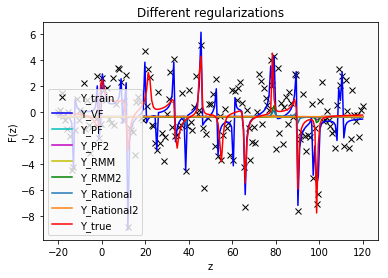

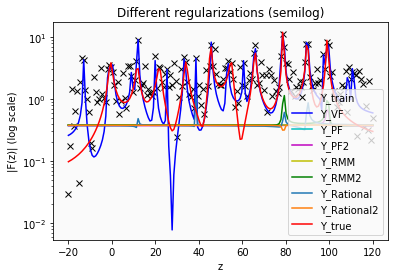

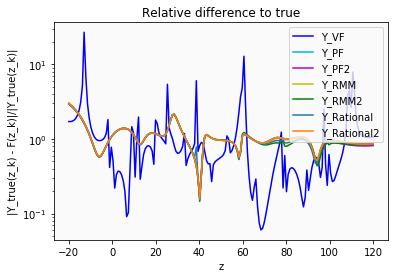

In [43]:
## Plotting PFBS results v/s VF results v/s the true model data (log-space data is in absolute value)
plt.figure()
plot_title = 'Different regularizations'
plt.plot(z_train, Y_train, 'x k', label='Y_train' )
plt.plot(z_train, Y_VF, 'b', label='Y_VF' )
#plt.plot(z_train, Y_PFBS, 'g', label='Y_PFBS')
plt.plot(z_train, Y_Pole_filtered, 'c', label='Y_PF')
plt.plot(z_train, Y_Pole_squared_filtered, 'm', label='Y_PF2')
plt.plot(z_train, Y_RMM_filtered, 'y', label='Y_RMM')
plt.plot(z_train, Y_RMM2_filtered, 'g', label='Y_RMM2')
plt.plot(z_train, Y_Rational_filtered, label='Y_Rational')
plt.plot(z_train, Y_Rational2_filtered, label='Y_Rational2')
plt.plot(z_train, Y_true, 'r', label='Y_true' )
#plt.ylim(-10, 20)
plt.xlabel('z')
plt.ylabel('F(z)')
plt.title(plot_title)
plt.legend()
pdf_title = "%s.%s"%(plot_title , 'pdf')
plt.savefig(pdf_title)

plt.figure()
plot_title = 'Different regularizations (semilog)'
plt.semilogy(z_train, np.abs(Y_train), 'x k', label='Y_train' )
plt.semilogy(z_train, np.abs(Y_VF), 'b', label='Y_VF' )
#plt.semilogy(z_train, np.abs(Y_PFBS), 'g', label='Y_PFBS')
plt.semilogy(z_train, np.abs(Y_Pole_filtered), 'c', label='Y_PF')
plt.semilogy(z_train, np.abs(Y_Pole_squared_filtered), 'm', label='Y_PF2')
plt.semilogy(z_train, np.abs(Y_RMM_filtered), 'y', label='Y_RMM')
plt.semilogy(z_train, np.abs(Y_RMM2_filtered), 'g',  label='Y_RMM2')
plt.semilogy(z_train, np.abs(Y_Rational_filtered), label='Y_Rational')
plt.semilogy(z_train, np.abs(Y_Rational2_filtered), label='Y_Rational2')
plt.semilogy(z_train, np.abs(Y_true), 'r', label='Y_true' )
#plt.ylim(-10, 20)
plt.xlabel('z')
plt.ylabel('|F(z)| (log scale)')
plt.title(plot_title)
plt.legend()
pdf_title = "%s.%s"%(plot_title , 'pdf')
plt.savefig(pdf_title)

plt.figure()
plot_title = 'Relative difference to true'
plt.semilogy(z_train, np.abs((Y_true - Y_VF)/Y_true), 'b', label='Y_VF' )
#plt.semilogy(z_train, np.abs((Y_true - Y_PFBS)/Y_true), 'g', label='Y_PFBS')
plt.semilogy(z_train, np.abs((Y_true - Y_Pole_filtered)/Y_true), 'c', label='Y_PF')
plt.semilogy(z_train, np.abs((Y_true - Y_Pole_squared_filtered)/Y_true), 'm', label='Y_PF2')
plt.semilogy(z_train, np.abs((Y_true - Y_RMM_filtered)/Y_true), 'y', label='Y_RMM')
plt.semilogy(z_train, np.abs((Y_true - Y_RMM2_filtered)/Y_true), 'g', label='Y_RMM2')
plt.semilogy(z_train, np.abs((Y_true - Y_Rational_filtered)/Y_true), label='Y_Rational')
plt.semilogy(z_train, np.abs((Y_true - Y_Rational2_filtered)/Y_true), label='Y_Rational2')
#plt.ylim(-10, 20)
plt.xlabel('z')
plt.ylabel('|Y_true(z_k) - F(z_k)|/|Y_true(z_k)|')
plt.title(plot_title)
plt.legend()
#plt.show()
pdf_title = "%s.%s"%(plot_title , 'pdf')
plt.savefig(pdf_title)

## Remaining (to be done)

There are only 3 things remaining at this stage: 
> • benchmark the VF alroghtm: in particular its ability to catch all the right poles if provided with (noisy) data. Because in the end we are supposing that VF would if given the right amount of poles. What if this is not the case?

> • Test which pole filtering regularization works best.

> • Test pole v/s residues regularization for final result with the right nuber of poles. 

> • It is likely that all the results depend on the form of the noise. Choose the right noise. 

> • Test RMM v/s brute force VF on time and performance. 

> • Implement and test the validity of the adaptive learning rates $\gamma_n = \frac{1}{2\sum_k \frac{\rho_k}{|z_k - p_n|^2}}$
 
 > • Propose, implement, and test relationship between noise and lambda $\lambda \sim \sigma$ with $\sigma \sim \sum_k \rho_k \left\| F(z_k) - Y_k \right\|_2^2$ 
 
 > • Test of real-case problem: oxygen-16 (good example because ENDF does not give the resonance parameters, so we can only "blindly" fit the date, and observe wether we find what R-matrix theory finds. If these are neutral-particle chanels, the fundamental assumption that we are searching for rational functions is valid, and then we are indeed testing the poerformance of the Rational Matrix Machine on noisy date for a real case. If it finds the exact solution, we could claim we have a "New Machine Learning Algorithm Learns Nuclear Physics", which is sexy enought, certainly for ICML, but if the algorithm is very good, why not in Nature Communciations. 

## Feature selection | Residues finding
Comparing the performance of Tichonov regularization, residues dampening regularization (with squares?), and direct least-squares